In [23]:
# %matplotlib notebook
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [220]:
#Global constants
DENSITY = 2.65 * 10**3
HEIGHT = 1
DIAMETER = 0.3
HEAT_CAPACITY = 1
COND_COEFF = 139.4
CONV_COEFF = 28
T_AMBIENT = 295
#Finite difference scheme
Nx = 40
Ny = 40
DX = DIAMETER/(Nx)
DY = DIAMETER/(Ny)
#Time integration
Total_time = 5

In [221]:
#Define points that fall inside wafer
def check_position_is_in_wafer(i,j):
    radius = DIAMETER/2
    distance_to_center = ((i - Nx//2)*DX)**2 + ((j - Ny//2)*DY)**2
    if  distance_to_center <= radius**2:
        return True
    else:
        return False
def list_positions_in_wafer():
    positions_in_wafer = []
    for i in range(Nx):
        for j in range(Ny):
            if check_position_is_in_wafer(i,j):
                positions_in_wafer.append([i,j])
    return positions_in_wafer

POINTS_IN_WAFER = list_positions_in_wafer()

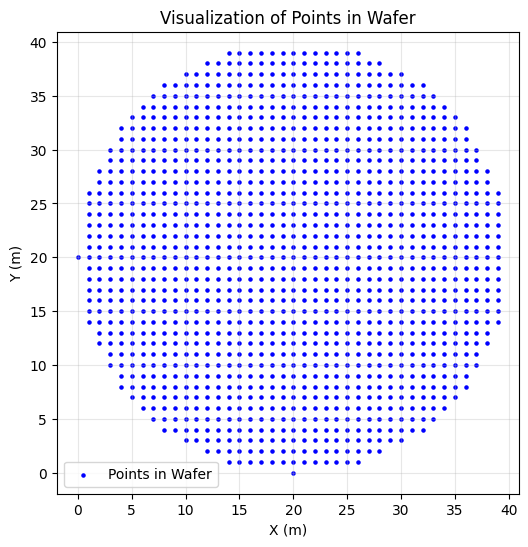

In [222]:
# Extract x and y coordinates for plotting
x_coords, y_coords = zip(*POINTS_IN_WAFER)

# Plotting the points
plt.figure(figsize=(6, 6))
plt.scatter(x_coords, y_coords, color='blue', s=5, label="Points in Wafer")
plt.gca().set_aspect('equal', adjustable='box')  # Ensure equal aspect ratio for proper circular shape
plt.title("Visualization of Points in Wafer")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [223]:
#BOUNDARY AND INITIAL CONDITIONS
T_initial = np.zeros((Nx, Ny), dtype=np.float64)
T_initial = T_initial + T_AMBIENT
#Wafer at different temperature
for point in POINTS_IN_WAFER:
    T_initial[point[0], point[1]] += 10
#perturbations
# T_initial[Nx//2 -5 : Nx//2 + 5, Ny//2 - 5:Ny//2 + 5] += 10

In [224]:
#Basic finite differences
def foward_difference(T, dx, i, j, axis, sign):
    #sign denotes whether the point that the temperature is compared to is before or after the current point
    if sign == 1: #after
        i_prime = i + 1
        j_prime = j + 1
    elif sign == -1: #before
        i_prime = i - 1
        j_prime = j - 1
    if (i == Nx - 1) or (j == Ny - 1) or (i == 0) or (j == 0):
        return (T_AMBIENT - T[i, j])/dx
    elif axis == 1:
        return (T[i_prime, j] - T[i, j])/dx
    elif axis == 2:
        return (T[i, j_prime] - T[i, j])/dx
    
# def backwards_difference(T, dx, i, j, axis):
#     if (i == 0) or (j == 0):
#         return (T[i,j] - T_AMBIENT)/dx
#     elif axis == 1:
#         return (T[i, j] - T[i-1, j])/dx
#     elif axis == 2:
#         return (T[i, j] - T[i, j-1])/dx


In [225]:
def pde_system(t, y):
    T = np.zeros_like(T_initial, dtype=np.float64)
    dTdt = np.zeros_like(T, dtype=np.float64)
    q_up = np.zeros_like(T, dtype=np.float64)
    q_down = np.zeros_like(T, dtype=np.float64)
    q_right = np.zeros_like(T, dtype=np.float64)
    q_left = np.zeros_like(T, dtype=np.float64)
    q_top = np.zeros_like(T, dtype=np.float64)

    for i in range(Ny):
        T[:,i] = y[Ny * i: Ny * (i+1)]

    for i in range(Nx):
        for j in range(Ny):
            if [i,j] in POINTS_IN_WAFER:
                q_up[i,j] = COND_COEFF * DX * HEIGHT * foward_difference(T, DY, i, j, axis=2, sign = 1)
                q_down[i,j] = COND_COEFF * DX * HEIGHT * foward_difference(T, DY, i  , j, axis=2, sign = -1)
                q_right[i,j] = COND_COEFF * HEIGHT * DY * foward_difference(T, DX, i, j, axis=1, sign = 1)
                q_left[i,j] = COND_COEFF * HEIGHT * DY * foward_difference(T, DX, i, j, axis=1, sign = -1)
                q_top [i,j] = CONV_COEFF * DX * DY * (T_AMBIENT - T[i,j])

                dTdt[i,j] = 1/(DENSITY * HEAT_CAPACITY * DX * DY * HEIGHT) * ( q_up[i,j] + q_down[i,j] + q_right[i,j] + q_left[i,j] + q_top[i,j])
            else:
                dTdt[i,j] = 0
    # for i in range(Nx - 1):
    #     #Boundary at the bottom
    #     q_up[i,0] = COND_COEFF * DX * DY * foward_difference(T, DY, i, 0, axis=2)
    #     q_down[i,0] = COND_COEFF * DX * DY * (T[i,0] - T_AMBIENT)/DY
    #     q_right[i,0] = COND_COEFF * DX * DY * foward_difference(T, DX, i, 0, axis=1)
    #     q_left[i,0] = COND_COEFF * DX * DY * backwards_difference(T, DX, i, 0, axis=1)
    #     q_top [i,0] = CONV_COEFF * DX * DY * (T_AMBIENT - T[i,0])
    #     dTdt[i,0] = 1/(DENSITY * HEAT_CAPACITY * DX * DY * HEIGHT) * ( q_up[i,0] + q_down[i,0] + q_right[i,0] + q_left[i,0] + q_top[i,0])
    
    #     #Boundary at the top
    #     q_up[i,Ny - 1] = COND_COEFF * DX * DY * (T_AMBIENT - T[i,Ny - 1])/DY
    #     q_down[i,Ny - 1] = COND_COEFF * DX * DY * backwards_difference(T, DY, i, Ny - 1, axis=2)
    #     q_right[i,Ny - 1] = COND_COEFF * DX * DY * foward_difference(T, DX, i, Ny - 1, axis=1)
    #     q_left[i,Ny - 1] = COND_COEFF * DX * DY * backwards_difference(T, DX, i, Ny - 1, axis=1)
    #     q_top [i,Ny - 1] = CONV_COEFF * DX * DY * (T_AMBIENT - T[i,Ny - 1])        
    #     dTdt[i,Ny - 1] = 1/(DENSITY * HEAT_CAPACITY * DX * DY * HEIGHT) * ( q_up[i,Ny - 1] + q_down[i,Ny - 1] + q_right[i,Ny - 1] + q_left[i,Ny - 1] + q_top[i,Ny - 1])
        
    #     #Boundary at the left (Assuming DX = DY)
    #     q_up[0,i] = COND_COEFF * DX * DY * foward_difference(T, DY, 0, i, axis=2)
    #     q_down[0,i] = COND_COEFF * DX * DY * backwards_difference(T, DY, 0, i, axis=2)
    #     q_right[0,i] = COND_COEFF * DX * DY * foward_difference(T, DX, 0, i, axis=1)
    #     q_left[0,i] = COND_COEFF * DX * DY * (T[0,i] - T_AMBIENT)/DX
    #     q_top [0,i] = CONV_COEFF * DX * DY * (T_AMBIENT - T[0,i])


    #     #Boundary at the right (Assuming DX = DY)  
    #     q_up[Nx - 1,i] = COND_COEFF * DX * DY * foward_difference(T, DY, i, j, axis=2)
    #     q_down[Nx - 1,i] = COND_COEFF * DX * DY * backwards_difference(T, DY, i, j, axis=2)
    #     q_right[Nx - 1,i] = COND_COEFF * DX * DY * foward_difference(T, DX, i, j, axis=1)
    #     q_left[Nx - 1,0] = COND_COEFF * DX * DY * backwards_difference(T, DX, i, j, axis=1)
    #     q_top [Nx - 1,0] = CONV_COEFF * DX * DY * (T_AMBIENT - T[i,j])
    return dTdt.flatten()

In [226]:
t0 = 0
tf = Total_time
y0 = T_initial.flatten()
sol1 = solve_ivp(pde_system, t_span=(0,tf), y0=y0, method="BDF")

In [227]:
len(sol1.t)

30

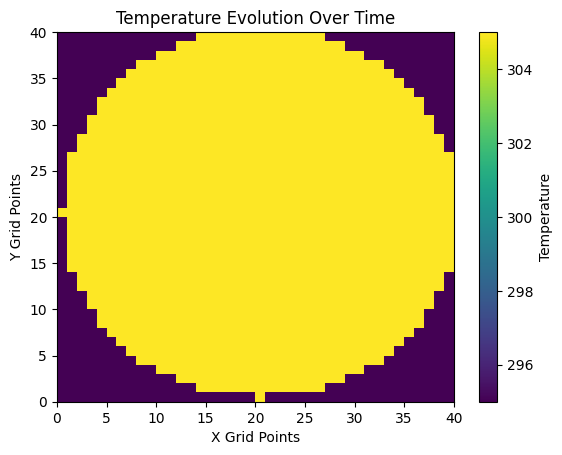

MovieWriter ffmpeg unavailable; using Pillow instead.


In [228]:
time_steps = len(sol1.t)
values = sol1.y.transpose()
values = values.reshape(time_steps, Ny, Nx)  # Reshape into (time_steps, Ny, Nx)

# Create the figure and axis
fig, ax = plt.subplots()
cax = ax.pcolormesh(values[0], shading='auto', cmap='viridis')  # Initial heatmap

# Add a colorbar to show the temperature scale
cbar = fig.colorbar(cax)
cbar.set_label('Temperature')

# Set up the plot title and labels
ax.set_title("Temperature Evolution Over Time")
ax.set_xlabel("X Grid Points")
ax.set_ylabel("Y Grid Points")

# Update function for the animation
def update(frame):
    cax.set_array(values[frame].flatten())  # Update the heatmap with the new time step
    ax.set_title(f"Temperature Evolution Over Time (Time step: {frame})")
    return cax,

# Create the animation
ani = FuncAnimation(fig, update, frames=time_steps, blit=False, interval=100)

# Display the animation
plt.show()

# Save the animation as a GIF (optional)
ani.save('temperature_evolution.gif', writer='ffmpeg', fps=2* time_steps/Total_time)